# 2. Landmark EKF

Your task is to implement an Landmark-EKF SLAM system and analyse the resulting state estimate.

You will estimate the robot state ${\bf x}_k = [x, y, \theta]^T$ and the state of each landmark ${\bf l}_i = [l_x, l_y ]^T$ resulting in the full state $\mathbf{Θ} = [{\bf x}, {\bf l}_0...{\bf l}_n]^T$ given $n$ landmarks.

We have provided a Simulator and key visualisation functions for you to use. This Simulator will provide ground truth robot pose, landmarks as well as noisy robot odometry and landmark measurements. Please study the code closely.

Robot odometry (or controls) are in the form ${\bf u_k }= [\delta x, \delta y, \delta \theta ]^T$ and represent the command velocity from $k$ to $k+1$.

Each landmark measurement contains the label and ${\bf m}_i = [m_x, m_y ]^T$ values of the landmark __as measurement in the robots local frame__.

Both control and landmark measurements are corrupted with Gaussian noise, the value of which is specified by the __arguments to the Simulation class constructor__.


Your task is to:
## a. Implement state transition and observation models
Implement the `utils.motion_model`, `utils.inverse_sensor_model` and `utils.sensor_model` functions. These will be useful to implement the EKF and include content taken directly from the lectures.

The motion model should implement $x_k = f(x_{k-1}, u_{k-1})$ as well as the Jacobians $G_1 = \frac{\partial f}{\partial x}$ and $G_2 = \frac{\partial f}{\partial u}$.

The sensor model should implement $z_i = h(x_k, l_i)$ as well as the Jacobians  $H_1 = \frac{\partial h}{\partial x}$ and $H_2 = \frac{\partial h}{\partial l}$.

>> NOTE: the simulation will not run until you have implemented `utils.motion_model` as this is needed to generate robot odometry.

Once implemented you should be able to run the Simulator and plot the ground truth trajectory and map. This code is provided and you should only need to run the main loop.


## b. Implement the EKF
Implement the EKF class by completing the `predict` and `update` functions.

After correct implementation you will need to update the internal state of the EKF class by copying your updated state mean and covariance values into the member variables:
```
self._state_vector = np.array(posterior_state_mean, copy=True)
self._state_covariance = np.array(posterior_state_covariance, copy=True)
```

Your state vector and covariance matrix will need to be augmented as you recieve measurements of new landmarks. You can assume all data-assocation (ie. labels of landmarks) will be correct.

## c. Validate your implementation

Once implemented you need to quantify the accuracy of your system.

- Calculate the ATE (absolute trajectory error) and RTE (relative trajectory error) of your estimate.
  - Report the RMSE (root-mean-squared error) of both metrics (ATE and RTE) which quantifies the accuracy over the whole simulation
- Report the per-time step ATE and RTE by plotting your error as a function of time. Consider how to visualise this data - should the _rotation_ and _translation_ components of the error be displayed together?
- Compare the error of your EKF when the update step is not used (only the predict step) with the full EKF (prediction and update).
  - The error should decrease when landmarks are observed and an update step is executed. When landmarks are not observed, what happens to the error _and_ the covariance of the robots state? Visualise these results to validate that your update function is working appropiately.
- Report the accuracy of your estimated map. Use the provided function `calculateMapError` to calculate this error.

We have provided visualisation functions that will enable your estimated pose and map to be visualised as an animation. This function takes many arguments to show the estimated/ground truth trajectory as well as the estimated landmarks. See the keyword arguments in `visualize_slam_animation` or uncomment the various arguments in `main`.


In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import matplotlib
from copy import deepcopy

from typing import List
import os
import pickle

In [20]:
class utils:
    @staticmethod
    def motion_model(pose, motion_command):
        """
        Implement the non-linear state-transition function x_k = f(x_{k-1}, u_{k-1})
        which returns x_k and Jacobians H1, H2

        Args:
            pose (_type_): x_{k-1}
            motion_command (_type_):  u_{k-1}

        Returns:
            _type_: new poses and Jacobians df\dx and df\du
        """
        # Initial x, y, theta 
        x_i = pose[0].item()
        y_i = pose [1].item()
        theta_i = pose[2].item()

        # Parameters in motion command 
        delta_d = motion_command[0].item()
        dy = motion_command[1].item()
        delta_theta = motion_command[2].item()

        # Updating the pose 
        x = x_i + delta_d*np.cos(theta_i)
        y = y_i + delta_d*np.sin(theta_i) + dy
        theta = theta_i + delta_theta 
        predicted_pose = np.array([[x], [y], [theta]])

        # Finding the Jacobians
        Gx = np.array([[1, 0 , -1*delta_d*np.sin(theta_i)], 
                       [0, 1, delta_d*np.cos(theta_i)], 
                       [0, 0, 1]])


        Gu = np.array([[np.cos(theta_i), 0, 0], 
                       [np.sin(theta_i), 0, 0], 
                       [0, 0, 1]])

        return predicted_pose, Gx, Gu
        

    @staticmethod
    def inverse_sensor_model(pose, relative_xy):
        """
        Implement the inverse of the sensor model h(x) where, given a relative sensor measurement and pose
        calculate the expected landmark location in the global frame.

        Pose will be an array [x,y,theta] and relative_xy is the [x,y] relative measurements of the landmark.

        Args:
            pose (_type_): np.array (3,1)
            relative_xy (_type_): np.array (2,1)

        Returns:
            _type_: Absolute landmark location and Jacobians df\dx df\dl
        """

        # Robot position 
        x = pose[0].item()
        y = pose[1].item()
        theta = pose[2].item()

        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                                    [np.sin(theta), np.cos(theta)]])

        # Relative x and y landmark positions 
        rel_x = relative_xy[0].item()
        rel_y = relative_xy[1].item()


        robot_position = np.array([[x], [y]])
        landmark_position = np.array([[rel_x], [rel_y]])

        # Finding absolute landmark position 
        absolute_landmark = robot_position + rotation_matrix @ landmark_position

        # Finding Jacobians 
        Hx = np.array([[1, 0, -rel_x*np.sin(theta) - rel_y*np.cos(theta)], 
                       [0, 1, rel_x*np.cos(theta) - rel_y*np.sin(theta)]])
        

        Hl = np.array([[np.cos(theta), -np.sin(theta)], 
                       [np.sin(theta), np.cos(theta)]])

        return absolute_landmark, Hx, Hl
        



    @staticmethod
    def sensor_model(pose, absolute_xy):
        """
            Implement sensor model h(x) where, given a absolute sensor measurement and pose
            calculate the expected landmark location in the local frame.

            This is used to calculate the expected measurement (in the local frame) given the current estimate
            of the robot and landmark

            Pose will be an array [x,y,theta] and absolute_xy is the [x,y] relative measurements of the landmark.

            Args:
                pose (_type_): np.array (3,1)
                absolute_xy (_type_): np.array (2,1)

            Returns:
                _type_: relative landmark location and Jacobians df\dx df\dl
        """
        
        # Extracting robot pose 
        x = pose[0].item()
        y = pose[1].item()
        theta = pose[2].item()

        rotation_matrix_T = np.array([[np.cos(theta), np.sin(theta)], 
                                      [-1*np.sin(theta), np.cos(theta)]])

        # Extracting relative landmark coordinates 
        l_x = absolute_xy[0].item()
        l_y = absolute_xy[1].item()

        delta_x = l_x - x
        delta_y = l_y - y

        landmark_position = np.array([[delta_x], [delta_y]])

        # Finding the relative landmark location 
        relative_landmark = rotation_matrix_T @ landmark_position

        # Finding the Jacobians 
        Hx = np.array([[-np.cos(theta), -np.sin(theta), -delta_x*np.sin(theta) + delta_y*np.cos(theta)], 
                       [np.sin(theta), -np.cos(theta), -delta_x*np.cos(theta) - delta_y*np.sin(theta)]])

        Hl = np.array([[np.cos(theta), np.sin(theta)], 
                       [-np.sin(theta), np.cos(theta)]])


        return relative_landmark, Hx, Hl
    

In [21]:
class LandmarkMeasurement:
    def __init__(self, label, x, y, covariance):
        self.label = label
        self.x = x
        self.y = y
        self.covariance = covariance

class ControlMeasurement:
    def __init__(self, motion_vector, covariance):
        # [dx, dy, dtheta]
        self.motion_vector = motion_vector
        self.covariance = covariance


In [22]:
class ExtendedKalmanFilter(object):

    def __init__(self) -> None:
        self._state_vector = np.array([[0.0], [0.0], [0.0]])
        self._state_covariance = np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])*10**(-3)

        self._landmark_index = {}

    @property
    def x(self):
        return deepcopy(self._state_vector[0])

    @property
    def y(self):
        return deepcopy(self._state_vector[1])

    @property
    def yaw(self):
        return deepcopy(self._state_vector[2])

    @property
    def pose(self):
        return np.array([self.x, self.y, self.yaw], copy=True)

    @property
    def pose_covariance(self):
        return np.array(self._state_covariance[0:3, 0:3], copy=True)

    @property
    def state_mean(self):
        return np.array(self._state_vector, copy=True)


    @property
    def landmarks(self):
        # TODO return np.array of n * 2 (where n is the number of landmarks in the state)
        # needed for vis

        landmarks = self._state_vector[3:]
        landmark_size = landmarks.shape[0]

        if landmark_size == 0: 
            return np.array([])
    
        return landmarks.reshape(-1, 2)

    @property
    def state_covariance(self):
        return np.array(self._state_covariance, copy=True)

    def predict(self, control_meaurement: ControlMeasurement):

        motion_command = control_meaurement.motion_vector
        covariance = control_meaurement.covariance

        # Predict state estimate
        pose, Gx, Gu = utils.motion_model(self._state_vector, motion_command)

        self._state_vector[0:3] = pose[0:3]


        # Update covariance estimate
        state_size = self._state_vector.shape[0]  
        F = np.eye(state_size)                    
        F[0:3, 0:3] = Gx     


        W = np.zeros((state_size, Gu.shape[1]))   
        W[0:3, 0:3] = Gu    

        self._state_covariance = F @ self._state_covariance @ F.T + W @ covariance @ W.T
        
    

    def update(self, landmark_measurements: List[LandmarkMeasurement]):
        # TODO Augment state vector and covariance if the landmark is new..
        for landmark in landmark_measurements: 
            l_label = landmark.label 
            l_x = landmark.x
            l_y = landmark.y
            l_covariance = landmark.covariance
            
            z_landmark = np.array([[l_x], [l_y]])

            if l_label not in self._landmark_index:

                # Find the position of the landmark
                landmark_pose, Hx, Hl = utils.inverse_sensor_model(self._state_vector, z_landmark)

                # Add the new landmark to the state vector 
                self._state_vector = np.vstack((self._state_vector, landmark_pose))

                # Update the covariance matrix 
                current_size = self._state_covariance.shape[0]
                current_matrix = self._state_covariance

                new_matrix = np.zeros((current_size + 2, current_size +2), dtype=current_matrix.dtype)
                new_matrix[:current_size, :current_size] = current_matrix
                new_covariance = Hl @ l_covariance @ Hl.T
                new_matrix[current_size: , current_size: ] = new_covariance

                self._state_covariance = new_matrix
                self._landmark_index[l_label] = current_size
            
            index = self._landmark_index[l_label]
            prev_landmark = self._state_vector[index:index+2]

            # TODO Calculate expected measurement
            z_expected, Hx_expected, Hl_expected = utils.sensor_model(self._state_vector, prev_landmark)

            # TODO Construct measurement Jacobian
            state_size = self._state_vector.shape[0]
            C = np.zeros((2, state_size))

            C[:, 0:3] = Hx_expected
            C[:, -2:] = Hl_expected


            # TODO Calculate the Innovation matrix
            innovation = z_landmark - z_expected
        

            # TODO Calculate the Kalman gain
            Q = l_covariance
            S = C @ self._state_covariance @ C.T + Q 
            K = self._state_covariance @ C.T @ np.linalg.inv(S)

            # TODO Update posterior mean and cov
            self._state_vector = self._state_vector + K @ innovation
            self._state_covariance = (np.eye(self._state_covariance.shape[0]) - K @ C)@ self._state_covariance 
            
            

In [23]:
class Simulation:
    def __init__(self, grid_size, num_landmarks, measurement_noise_std, linear_odometry_noise_std, angular_odometry_noise_std, fov_range, fov_angle, **kwargs):
        self.grid_size = grid_size
        self.num_landmarks = num_landmarks
        self.measurement_noise_std = measurement_noise_std
        self.linear_odometry_noise_std = linear_odometry_noise_std
        self.angular_odometry_noise_std = angular_odometry_noise_std
        self.robot_pose = np.array([[0.0], [0.0], [0.0]])  # Initial robot pose
        self.fov_range = fov_range
        self.fov_angle = fov_angle
        self.dt = 0.1 #Time step
        self.target_landmark_index = 0

        lmks_file_path = kwargs.get("landmarks_file", None)
        save_file = kwargs.get("save_file", False)

        if lmks_file_path is not None:
            try:
                self.landmarks = self.load_landmarks(lmks_file_path)
            except Exception as e:
                print(f"Failed to load lmks from file. Geneating new lmks!")
                self.landmarks = self.generate_landmarks()
        else:
            self.landmarks = self.generate_landmarks()

        if save_file:
            self.save_landmarks(file_path="lmks.txt")


    def generate_landmarks(self):
        landmarks = []
        for i in range(self.num_landmarks):
            x = random.uniform(-self.grid_size / 2, self.grid_size / 2)
            y = random.uniform(-self.grid_size / 2, self.grid_size / 2)
            landmarks.append((i, x, y))  # (label, x, y)
        return landmarks

    def load_landmarks(self, file_path):
        print(f"Loading lmks from file {file_path}")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"The file {file_path} does not exist.")

        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)

            if not isinstance(data, list) or not all(isinstance(item, tuple) for item in data):
                raise ValueError("The file does not contain a valid list of tuples.")

            return data
        except (IOError, pickle.UnpicklingError) as e:
            raise IOError(f"Error reading the file {file_path}: {e}")

    def save_landmarks(self, file_path="lmks.txt"):
        print(f"Saving lmks to file {file_path}")
        if not isinstance(self.landmarks, list) or not all(isinstance(item, tuple) for item in self.landmarks):
            raise ValueError("Data must be a list of tuples.")

        try:
            with open(file_path, 'wb') as f:
                pickle.dump(self.landmarks, f)
        except IOError as e:
            raise IOError(f"Error writing to file {file_path}: {e}")


    def generate_odometry_measurement(self, delta_d, delta_theta):
        # Add noise to odometry
        noisy_delta_d = delta_d + np.random.normal(0, self.linear_odometry_noise_std)
        noisy_delta_theta = delta_theta + np.random.normal(0, self.angular_odometry_noise_std)

        # no control along y
        dy = 0
        #just a small value as there is no motion along y of the robot
        s_linear_vel_y = 0.000000001

        # Update true robot pose
        self.robot_pose, _, _ = utils.motion_model(self.robot_pose, np.array([[delta_d], [dy], [delta_theta]]))

        # Create ControlMeasurement object
        covariance = np.diag([self.linear_odometry_noise_std**2, s_linear_vel_y**2, self.angular_odometry_noise_std**2])
        return ControlMeasurement(np.array([[noisy_delta_d], [dy], [noisy_delta_theta]]), covariance)

    def generate_landmark_measurement(self, landmark_index, robot_pose):
        label, lx, ly = self.landmarks[landmark_index]

        relative_l, _, _ =utils.sensor_model(robot_pose, np.array([lx, ly]))
        relative_x, relative_y = relative_l.flatten()

        # # Add noise to measurement
        noisy_relative_x = relative_x + np.random.normal(0, self.measurement_noise_std)
        noisy_relative_y = relative_y + np.random.normal(0, self.measurement_noise_std)

        # Create LandmarkMeasurement object
        covariance = np.diag([self.measurement_noise_std**2, self.measurement_noise_std**2])
        return LandmarkMeasurement(label, noisy_relative_x, noisy_relative_y, covariance)

    def get_true_robot_pose(self):
        return self.robot_pose

    def get_landmarks(self):
        return self.landmarks

    def step(self, t):
        # Generate control input based on time
        delta_d, delta_theta = self.generate_control_input(t)

        # Move the robot with noise
        control_measurement = self.generate_odometry_measurement(delta_d, delta_theta)
        return control_measurement


    def get_landmark_measurements(self, pose):
        visible_landmarks = self.get_visible_landmarks(pose)
        measurements = []
        for landmark_index in visible_landmarks:
            measurements.append(self.generate_landmark_measurement(landmark_index, pose))
        return measurements, visible_landmarks


    #     return delta_d, delta_theta
    def generate_control_input(self, t):
      """Generates control inputs to visit landmarks."""
      rx, ry, rtheta = self.robot_pose.flatten()
      target_lx, target_ly = self.landmarks[self.target_landmark_index][1], self.landmarks[self.target_landmark_index][2]

      delta_x = target_lx - rx
      delta_y = target_ly - ry
      angle_to_target = np.arctan2(delta_y, delta_x)

      # Calculate angle difference
      angle_diff = angle_to_target - rtheta
      angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

      # Calculate distance to target
      distance_to_target = np.sqrt(delta_x**2 + delta_y**2)

    # Control parameters
      angular_speed_gain = 0.5  # Proportional gain for angular speed
      linear_speed_gain = 0.1  # Proportional gain for linear speed
      max_angular_speed = 1.0 # Maximum allowed angular speed
      max_linear_speed = 0.5 # Maximum allowed linear speed

      # Generate control inputs with proportional gains
      delta_theta = angular_speed_gain * angle_diff
      delta_d = linear_speed_gain * distance_to_target

      # Clip values to maximum speeds multiplied by dt
      delta_theta = np.clip(delta_theta, -max_angular_speed * self.dt, max_angular_speed * self.dt)
      delta_d = np.clip(delta_d, 0, max_linear_speed * self.dt)

      # Check if reached the target
      if distance_to_target < 3.0:  # Threshold for reaching the target
          self.target_landmark_index = (self.target_landmark_index + 1) % len(self.landmarks)

      return delta_d, delta_theta

    def get_visible_landmarks(self, robot_pose):
        visible_landmarks = []
        rx, ry, rtheta = robot_pose.flatten()
        for i, (label, lx, ly) in enumerate(self.landmarks):
            delta_x = lx - rx
            delta_y = ly - ry
            range_to_landmark = np.sqrt(delta_x**2 + delta_y**2)
            angle_to_landmark = np.arctan2(delta_y, delta_x) - rtheta

            # Normalize angle to [-pi, pi]
            angle_to_landmark = (angle_to_landmark + np.pi) % (2 * np.pi) - np.pi

            if range_to_landmark <= self.fov_range and abs(angle_to_landmark) <= self.fov_angle / 2:
                visible_landmarks.append(i)
        return visible_landmarks



In [24]:
def calculateMapError(simulation: Simulation, landmarks_ekf):
    """
    Calculates the error between ground truth data and the data obtained after SLAM and returns the total error.
    landmarks ekf should be a dictionary mapping the label id (index) of the landmark to its position in the global frame
    e.g. {1: [x, y], 2: [x,y]}...
    returns map error
    """

    # N x 3 array in the form (label, x, y)
    landmarks_ground_truth = simulation.get_landmarks()

    if len(landmarks_ekf) == 0:
      print("No landmarks found ")

    landmark_gt = {}

    # convert gt landmarks to map
    for landmark in landmarks_ground_truth:
        landmark_gt[landmark[0]] = [landmark[1], landmark[2]]

    # Compute positions of landmarks relative to the positions of another landmark
    landmark_error = []
    landmark_gt_ids = landmark_gt.keys()


    missed_lmks = []
    for landmark_id, _ in landmark_gt.items():
        if landmark_id not in landmarks_ekf:
            print(f"Ground truth lmk id {landmark_id} does not appear in your estimate!")
            missed_lmks.append(landmark_id)

    additional_lmks = []
    matched_mks = []

    for landmark_id, relative_pos in landmarks_ekf.items():
        if landmark_id not in landmark_gt_ids:
            additional_lmks.append(landmark_id)
            print(f"Your solution has lmk id {landmark_id} which does not occur in the ground truth")
        else:
            matched_mks.append(landmark_id)

    def relativeLandmarkPositions(landmark_position_abs, next_landmark_position_abs):
      # label is in position [0], hence use positions [1] and [2]
      x1 = float(landmark_position_abs[1])
      y1 = float(landmark_position_abs[2])
      x2 = float(next_landmark_position_abs[1])
      y2 = float(next_landmark_position_abs[2])

      # Calculate the difference of position in world frame
      diff = [x2-x1, y2-y1]

      return diff


    for i in range(0, len(matched_mks) - 1):
        lmk_id_1 = matched_mks[i]
        lmk_id_2 = matched_mks[i+1]

        predicted_pos_1 = [lmk_id_1, landmarks_ekf[lmk_id_1][0], landmarks_ekf[lmk_id_1][1]]
        gt_pos_1 = [lmk_id_1, landmark_gt[lmk_id_1][0], landmark_gt[lmk_id_1][1]]

        predicted_pos_2 = [lmk_id_2, landmarks_ekf[lmk_id_2][0], landmarks_ekf[lmk_id_2][1]]
        gt_pos_2 = [lmk_id_2, landmark_gt[lmk_id_2][0], landmark_gt[lmk_id_2][1]]

        landmarks_pred_rel = relativeLandmarkPositions(predicted_pos_1,predicted_pos_2)
        landmarks_gt_rel = relativeLandmarkPositions(gt_pos_1, gt_pos_2)

        landmark_error.append(np.array(landmarks_gt_rel) - np.array(landmarks_pred_rel))

    if len(landmarks_ekf) > 1:
        error_landmark = (1.0/(len(landmarks_ekf)-1))*np.linalg.norm(landmark_error)
    else:
        error_landmark = 0.

    return error_landmark

In [25]:

def calculateAteRte(trajectory, ekf_trajectory):

    ate = []
    rte = []
    
    trajectory = np.array(trajectory)
    ekf_trajectory = np.array(ekf_trajectory)
    
    # ATE - Euclidean distance between true and estimated poses
    for true_pose, est_pose in zip(trajectory, ekf_trajectory):
        error = np.sqrt((true_pose[0, 0] - est_pose[0, 0])**2 + 
                              (true_pose[1, 0] - est_pose[1, 0])**2)
        ate.append(error)
    
    # RTE - Relative error between consecutive poses
    for i in range(1, len(trajectory)):
        true_diff = trajectory[i] - trajectory[i-1]
        true_trans = np.sqrt(true_diff[0, 0]**2 + true_diff[1, 0]**2)
    
        est_diff = ekf_trajectory[i] - ekf_trajectory[i-1]
        est_trans = np.sqrt(est_diff[0, 0]**2 + est_diff[1, 0]**2)
        
        rte_error = np.abs(true_trans - est_trans)
        rte.append(rte_error)
    
    # Root Mean Square
    Ate = np.array(ate)
    ate_rms = np.sqrt(np.mean(Ate**2))
    
    Rte = np.array(rte)
    rte_rms = np.sqrt(np.mean(Rte**2)) if len(rte) > 0 else 0.0
    
    return ate, rte, ate_rms, rte_rms

In [26]:
from matplotlib import patches
def plot_covariance_ellipse_2d(axes, origin, covariance: np.ndarray, ellipse_patch=None):
    """
    Plots a Gaussian as an uncertainty ellipse.

    The ellipse is scaled in such a way that 95% of drawn samples are inliers.
    Derivation of the scaling factor is explained at the beginning of this file.

    Args:
        axes (matplotlib.axes.Axes): Matplotlib axes.
        origin: The origin in the world frame.
        covariance: The marginal covariance matrix of the 2D point
                    which will be represented as an ellipse.
        ellipse_patch: An existing ellipse patch to update (for animation).
                       If None, a new patch is created.
    """

    w, v = np.linalg.eigh(covariance)

    # this corresponds to 95%, see note above
    k = 2.447746830681
    x,y,_ = origin

    angle = np.arctan2(v[1, 0], v[0, 0])
    # We multiply k by 2 since k corresponds to the radius but Ellipse uses
    # the diameter.
    if ellipse_patch is None:
        e1 = patches.Ellipse((x, y),
                             np.sqrt(w[0]) * 2 * k,
                             np.sqrt(w[1]) * 2 * k,
                             angle=np.rad2deg(angle),
                             fill=False,
                             color='orange',
                             label='Covariance')
        axes.add_patch(e1)
        return e1  # Return the created patch for future updates
    else:
        ellipse_patch.center = (x, y)
        ellipse_patch.width = np.sqrt(w[0]) * 2 * k
        ellipse_patch.height = np.sqrt(w[1]) * 2 * k
        ellipse_patch.angle = np.rad2deg(angle)
        return ellipse_patch  # Return the updated patch



def visualize_slam_animation(fig, ax, simulation, as_animation=False, **kwargs):
    """Visualizes the SLAM simulation with EKF updates."""

    trajectory = kwargs.get("trajectory", None)
    visible_landmarks_history = kwargs.get("visible_landmarks_history", None)
    ekf_trajectory_history = kwargs.get("ekf_trajectory_history", None)
    ekf_covariance_history = kwargs.get("ekf_covariance_history", None)
    ekf_landmarks_history = kwargs.get("ekf_landmarks_history", None)
    ekf_predict_trajectory_history = kwargs.get("ekf_predict_trajectory_history", None)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('SLAM EKF Trajectory')
    ax.grid(True)
    ax.set_aspect('equal')

    # Plot static elements (landmarks)
    x_landmarks = [lm[1] for lm in simulation.landmarks]
    y_landmarks = [lm[2] for lm in simulation.landmarks]
    landmarks_plot = ax.scatter(x_landmarks, y_landmarks, marker='x', color='blue', label='Landmarks')

    axis_elements = []
    trajectory_plot = None
    # Initialize dynamic elements
    if trajectory:
        trajectory_plot, = ax.plot([], [], marker='.', linestyle='-', color='green', label='True Robot Trajectory')
        axis_elements.append(trajectory_plot)

    ekf_trajectory_plot = None
    if ekf_trajectory_history:
        ekf_trajectory_plot, = ax.plot([], [], marker='.', linestyle='-', color='blue', label='EKF Robot Trajectory')
        axis_elements.append(ekf_trajectory_plot)

    ekf_predict_trajectory_plot = None
    if ekf_predict_trajectory_history:
        ekf_predict_trajectory_plot, = ax.plot([], [], marker='.', linestyle='-', color='red', label='EKF (Predict) Robot Trajectory')
        axis_elements.append(ekf_predict_trajectory_plot)

    visible_landmarks_plot = None
    if visible_landmarks_history:
        visible_landmarks_plot = ax.scatter([], [], marker='o', color='red', label='Visible Landmarks')
        axis_elements.append(visible_landmarks_plot)

    estimated_landmarks_plot = None
    if ekf_landmarks_history:
        estimated_landmarks_plot = ax.scatter([], [], marker='x', color='green', label='Estimated Landmarks')
        axis_elements.append(estimated_landmarks_plot)
    # covariance_ellipse, = ax.plot([], [], color='orange', label='Covariance')
    ellipse_patch = None  # Initialize ellipse patch

    def update(frame):

        if trajectory_plot:
            current_traj = np.array(trajectory[:frame + 1])
            trajectory_plot.set_data(current_traj[:, 0, 0], current_traj[:, 1, 0])

        if ekf_trajectory_plot:
            current_ekf_traj = np.array(ekf_trajectory_history[:frame + 1])
            ekf_trajectory_plot.set_data(current_ekf_traj[:, 0, 0], current_ekf_traj[:, 1, 0])

        if ekf_predict_trajectory_plot is not None and frame < len(ekf_predict_trajectory_history) - 1:
            current_ekf_predict_traj = np.array(ekf_predict_trajectory_history[:frame + 1])
            ekf_predict_trajectory_plot.set_data(current_ekf_predict_traj[:, 0, 0], current_ekf_predict_traj[:, 1, 0])

        if estimated_landmarks_plot is not None:
            if frame < len(ekf_landmarks_history):
                est_x = [lmk[0] for lmk in ekf_landmarks_history[frame]]
                est_y = [lmk[1] for lmk in ekf_landmarks_history[frame]]
                estimated_landmarks_plot.set_offsets(np.column_stack((est_x, est_y)))
            else:
                estimated_landmarks_plot.set_offsets(np.empty((0, 2)))

        if visible_landmarks_plot is not None:
            if frame < len(visible_landmarks_history):
                visible_x = [simulation.landmarks[i][1] for i in visible_landmarks_history[frame]]
                visible_y = [simulation.landmarks[i][2] for i in visible_landmarks_history[frame]]
                visible_landmarks_plot.set_offsets(np.column_stack((visible_x, visible_y)))
            else:
                visible_landmarks_plot.set_offsets(np.empty((0, 2)))

        nonlocal ellipse_patch  # Use nonlocal to modify ellipse_patch
        if ekf_covariance_history is not None and frame < len(ekf_covariance_history):
            mu = ekf_trajectory_history[frame]
            P = ekf_covariance_history[frame][:2, :2]
            # plot_covariance_ellipse_2d(covariance_ellipse, mu, P)
            ellipse_patch = plot_covariance_ellipse_2d(ax, mu, P, ellipse_patch)
        else:
            ellipse_patch = None

        return *axis_elements, ellipse_patch

    if as_animation:
      ani = animation.FuncAnimation(fig, update, frames=len(trajectory), interval=20, blit=True)
      ax.legend()
      return ani
    else:
      for frame in range(len(trajectory)):
        update(frame)

      ax.legend()
      return fig


Loading lmks from file lmks.txt
Saving lmks to file lmks.txt


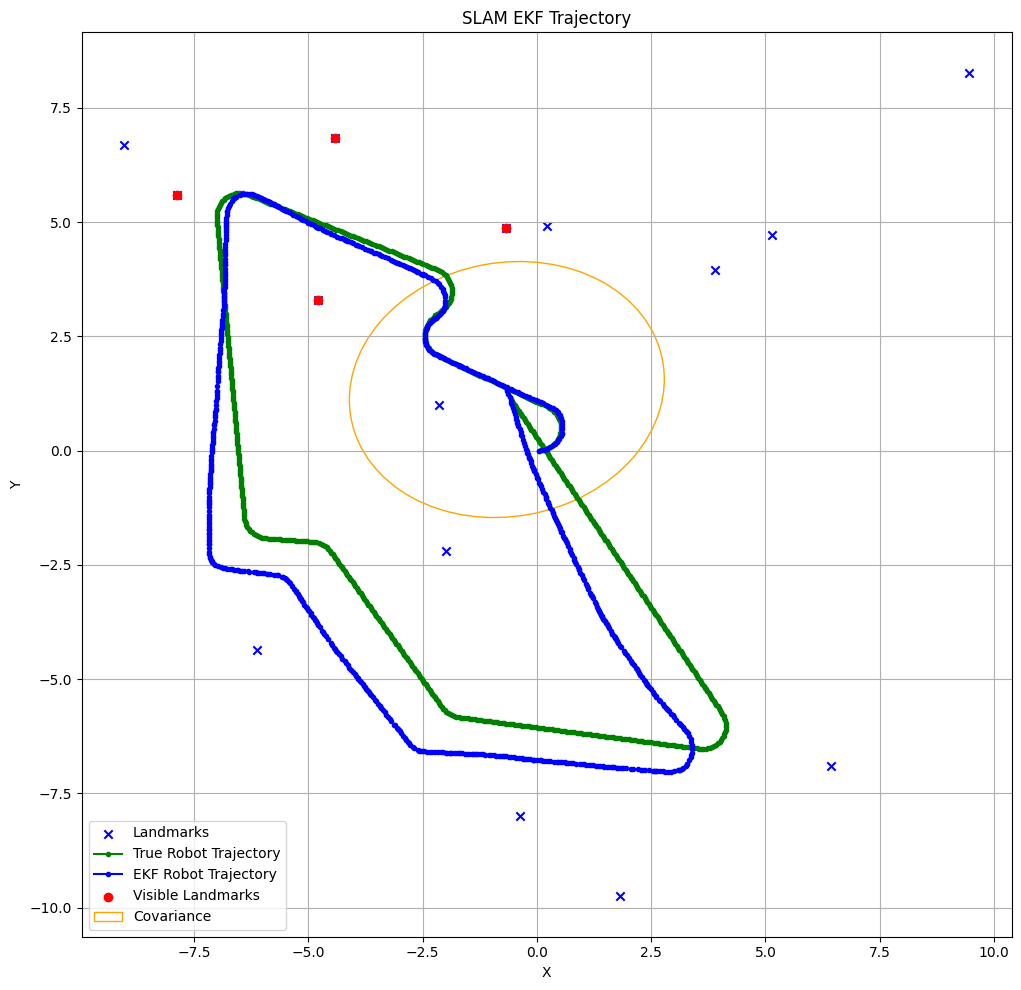

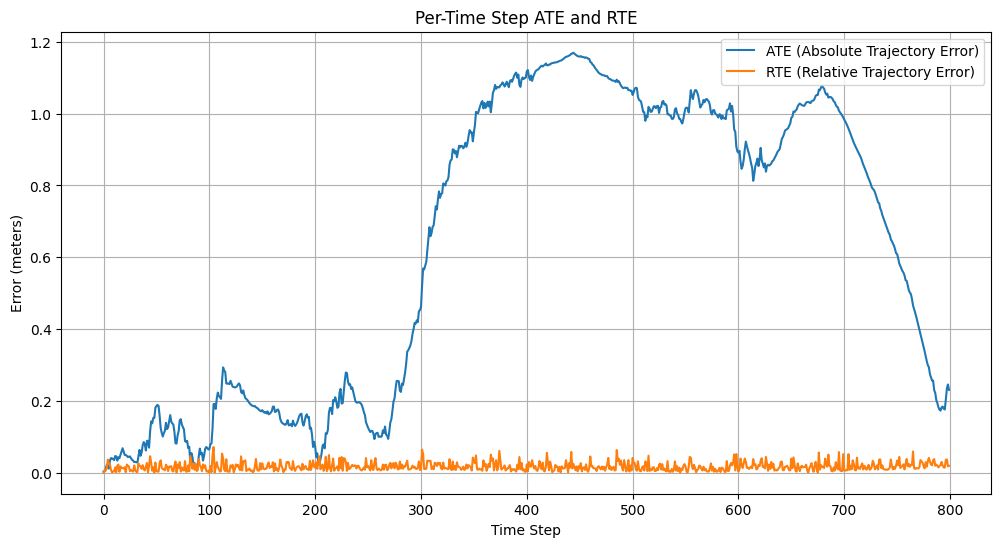

ATE RMS: 0.7584
RTE RMS: 0.0199
No landmarks found 
Ground truth lmk id 0 does not appear in your estimate!
Ground truth lmk id 1 does not appear in your estimate!
Ground truth lmk id 2 does not appear in your estimate!
Ground truth lmk id 3 does not appear in your estimate!
Ground truth lmk id 4 does not appear in your estimate!
Ground truth lmk id 5 does not appear in your estimate!
Ground truth lmk id 6 does not appear in your estimate!
Ground truth lmk id 7 does not appear in your estimate!
Ground truth lmk id 8 does not appear in your estimate!
Ground truth lmk id 9 does not appear in your estimate!
Ground truth lmk id 10 does not appear in your estimate!
Ground truth lmk id 11 does not appear in your estimate!
Ground truth lmk id 12 does not appear in your estimate!
Ground truth lmk id 13 does not appear in your estimate!
Ground truth lmk id 14 does not appear in your estimate!
Map Error: 0.0000


In [27]:
simulation = Simulation(
    grid_size=20,
    num_landmarks=15,
    measurement_noise_std=0.01,
    linear_odometry_noise_std=0.02,
    angular_odometry_noise_std=0.01,
    fov_range=10,
    fov_angle=np.pi/2,
    landmarks_file="lmks.txt",
    save_file=True)

ekf = ExtendedKalmanFilter()
trajectory = []
visible_landmarks_history = []
ekf_trajectory_history = []
ekf_predict_trajectory_history = []
ekf_covariance_history = []
ekf_landmarks_history = []

ate_errors = []
rte_errors = []

num_steps = 800
ekf_update_interval = 2

for t in range(num_steps):
    control_measurement = simulation.step(t)
    true_pose = simulation.get_true_robot_pose()
    trajectory.append(true_pose)

    ekf.predict(control_measurement)

    measurements, visible = simulation.get_landmark_measurements(true_pose)
    visible_landmarks_history.append(visible)

    # if t % ekf_update_interval == 0:
    #     ekf.update(measurements)
    # ekf_landmarks_history.append(ekf.landmarks)

    ekf_trajectory_history.append(ekf.pose)
    ekf_covariance_history.append(ekf.pose_covariance)

    # Compute ATE 
    est_pose = ekf.pose[:2, 0]  
    true_pose_xy = true_pose[:2, 0]
    ate_error = np.linalg.norm(est_pose - true_pose_xy)
    ate_errors.append(ate_error)

    # Compute RTE 
    if t > 0:
        true_diff = true_pose_xy - trajectory[t-1][:2, 0]
        est_diff = est_pose - ekf_trajectory_history[t-1][:2, 0]
        rte_error = np.linalg.norm(true_diff - est_diff)
        rte_errors.append(rte_error)
    else:
        rte_errors.append(0)  



fig, ax = plt.subplots(figsize=(12, 12))

visualize_slam_animation(fig, ax, simulation, as_animation=False,
                                trajectory=trajectory,
                                visible_landmarks_history=visible_landmarks_history,
                                ekf_trajectory_history=ekf_trajectory_history,
                                ekf_covariance_history=ekf_covariance_history,
                                ekf_landmarks_history= ekf_landmarks_history,
                                ekf_predict_trajectory_history=ekf_predict_trajectory_history
                         )

plt.show()

time_steps = np.arange(num_steps)

plt.figure(figsize=(12, 6))
plt.plot(time_steps, ate_errors, label='ATE (Absolute Trajectory Error)')
plt.plot(time_steps, rte_errors, label='RTE (Relative Trajectory Error)')
plt.xlabel('Time Step')
plt.ylabel('Error (meters)')
plt.title('Per-Time Step ATE and RTE')
plt.legend()
plt.grid(True)
plt.show()


#Calculating error 
### ATE and RTE ###
ate, rte, ate_rms, rte_rms = calculateAteRte(trajectory, ekf_trajectory_history)

print(f"ATE RMS: {ate_rms:.4f}")
print(f"RTE RMS: {rte_rms:.4f}")

### MAP ERROR ###
landmarks_ekf = {label: pos for label, pos in zip(ekf._landmark_index.keys(), ekf.landmarks)}
map_error = calculateMapError(simulation, landmarks_ekf)
print(f"Map Error: {map_error:.4f}")